# Modern Recurrent Neural Networks

- Major issue with RNNs is their succeptability to vanishing and exploding gradients. The introduction of gradient clipping is one way to deal with the exploding gradients issue, but leaves the problem of vanishing gradients unsolves.

- Long Short Term Memory (LSTM) architectures are one innovation that has tackled the issue of vanishing gradients.

- Bidirectional RNNs are another innovation that allows the _future_ of models to impact predictions in the past. Useful for machine translation etc.

# Long Short-Term Memory Networks

- Each ordinary recurrent node is replaced by a so-called "memory cell". 
    - Each memory cell contains an internal state, i.e. a hidden state with a fixred weight weight 1 (I guess the same as an RNN)
    - The term long short-term memory comes from the following. Traditional RNNs have long term memory in the sense that the weights of their hidden states change very slowly over time, and could be considered to contain information about all of the data leading to that state. They also have short term memory in the sense of larger, ephemeral activations of those weights caused by particular data. (or pass from node to node).
        - LSTM introduces an intermediate form of "memory". The memory cell; a composite unit of simpler nodes in a specific connectivity pattern.

## Gated Memory Cell

- Each memory cell contains a hidden state, alongside a number of multiplicative gates which determine whether:
1. A given input should affect the internal state (the input gate)
2. The internal state should be reset to 0 (i.e. the forget gate)
3. the internal state of a particular neuron should affect the neuron's output (the output gate)

### Gated Hidden State

The key distinction is that the updating and accessing of the hidden state is gated behind a learned function. For example, if the first token in a sequence is of particular importance, the model may learn not to update the hidden state of a particular node after the first observation. On the flipside, it may also learn to ignore irrelevant observations, and learn when to flush/reset the internal state entirely. 

### Input Gate, Output Gate, Forget Gate

The data being fed into an LSTM at each step are the hidden state from the previous step and the input for the current step. There are three fully connected layers activated with sigmoid functions which ensure that the gate ouput values are in (0, 1), there is an additional input _node_ component. Intuitively, the input gate determines how much of the input nodes' values should be added to the hidden state of the LSTM, the output gate controls how much of the input is added to the output, and the forget gate determines whether or not the hidden state is flushed. 

### Mathematically... 

We suppose that there are $h$ hidden units, the batch size is $n$ and the number of inputs is $d$. So we have an input of $\mathbf{X} \in \mathbb{R}^{n \times d}$ and a hidden state from the previous timestep of $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$. Correspondingly, the three gates at timestep $t$ are defined as $\mathbf{I}_t \in \mathbb{R}^{n \times h}$, the output gate as $\mathbf{O}_t \in \mathbb{R}^{n \times h}$ and the forget gate as $\mathbf{F}_t \in \mathbb{R}^{n \times h}$.

They are calculated with:

$$ \mathbf{I}_t = \sigma (\mathbf{X}_t\mathbf{W}_{xi} + \mathbf{H}_{t-1}*\mathbf{W}_{hi} + \mathbf{b}_i) $$
$$ \mathbf{F}_t = \sigma (\mathbf{X}_t\mathbf{W}_{xf} + \mathbf{H}_{t-1}*\mathbf{W}_{hf} + \mathbf{b}_f) $$
$$ \mathbf{O}_t = \sigma (\mathbf{X}_t\mathbf{W}_{xo} + \mathbf{H}_{t-1}*\mathbf{W}_{ho} + \mathbf{b}_o) $$

### Input Node

We define an equation for the input node $\mathbf{\tilde{C}}$ which is similar but uses a tanh function instead of the sigmoid. 

$$ \mathbf{\tilde{C}}_t = tanh(\mathbf{X}_t\mathbf{W}_{xc} + \mathbf{H}_{t-1}\mathbf{W}_{hc} + \mathbf{b}_c) $$

In short, at this stage of the explanmation, there are three identical learned functions, which are extremely similar to invididual functions comprising and RNN, and a fourth, which only differs in its use of a tanh activation function instead of a sigmoid. 

### Memory Cell internal state

$\odot\odot\odot\odot\odot\odot\odot\odot\odot\odot\odot\odot\odot\odot\odot\odot\odot\odot\odot\odot\odot\odot\odot\odot\odot$

In an LSTM, the input gate determines how much of the input is used to compute the new internal cell state ($\mathbf{C}_{t}$) while the forget gate determines how much of the previous state (C_{t-1}) is forgotten. 

$$ \mathbf{C}_t = \mathbf{I}_t \odot \mathbf{\tilde{C}}_{t} + \mathbf{F}_t \odot \mathbf{C}_{t-1}$$ 

So if the forget gate is 1, and the input gate is 0, the internal state of the memory cell will remain fixed forever. In practise, this innovation allows the model to learn/decide when to keep the value of the internal state unchanged, and when to update it. 

### Hidden State

Last, we look at how to actually comput the output of the memory cell, i.e. the hidden state seen by other layers. Essentially we take tanh of the memory cell hidden state, and multiply by the values of the output gate. 

$$ \mathbf{H}_t = \mathbf{O}_{t} \odot tanh({\mathbf{C}_t})

## Implementation From Scratch

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [7]:
class LSTMScratch(d2l.Module):

    def __init__(self, num_hiddens: int, num_inputs: int, sigma: float = 0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)

        triple = lambda: (
            init_weight(num_inputs, num_hiddens),
            init_weight(num_hiddens, num_hiddens),
            nn.Parameter(torch.zeros(self.num_hiddens))
        )

        # Same format/setup for Input, Forget, Outpu gates and Input Node.
        self.W_xi, self.W_hi, self.b_i = triple()
        self.W_xf, self.W_hf, self.b_f = triple()
        self.W_xo, self.W_ho, self.b_o = triple()
        self.W_xc, self.W_hc, self.b_c = triple()

    def forward(self, inputs, H_C=None):
        if H_C is None:
            H = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
            C = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
        else:
            H, C = H_C

        outputs = []
        for X in inputs:

            # Gates
            # Input
            I = torch.sigmoid(torch.matmul(X, self.W_xi) + torch.matmul(H, self.W_hi) + self.b_i)
            # Forget
            F = torch.sigmoid(torch.matmul(X, self.W_xf) + torch.matmul(H, self.W_hf) + self.b_f)
            # output
            O = torch.sigmoid(torch.matmul(X, self.W_xo) + torch.matmul(H, self.W_ho) + self.b_o)

            # Input Node
            C_tilde = torch.tanh(torch.matmul(X, self.W_xc) + torch.matmul(H, self.W_hc) + self.b_c)

            # Gated output C with hadamard product
            C = F * C + I * C_tilde

            H = O * torch.tanh(C)
            outputs.append(H)

        return outputs, (H, C)
            

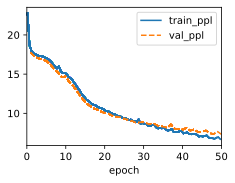

In [8]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [9]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has the the the the the'

In [15]:
# Consise implementation using torch

class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(
            self.num_inputs,
            self.num_hiddens
        )

    def forward(self, inputs, state=None):
        return self.rnn(inputs, state)

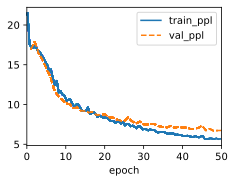

In [16]:
lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [17]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has on a ment on the th'

Many variants of the basic LSTM covered here have been covered in the literature, including multiple layers, residual connections and employing different types of regularisation. Training them is quite costly due to the long range dependency of the sequence, which is a problem which was fixed with the transformer architecture discussed later.

LSTMS were the dominant sequence modelling technology from 2011 through to 2017, when the introduction of the transformer architecture largely obviated them. 